# Anomaly Detection

This notebook shows some basic usage of CapyMOA for Anomaly Detection tasks.

Algorithms: `HalfSpaceTrees`, `Autoencoder` and `Online Isolation Forest`

---

*More information about CapyMOA can be found in* https://www.capymoa.org

**last update on 29/07/2024**

## 1. Creating simple anomalous data with `sklearn`

* Generating a few examples and some simple anomalous data using `sklearn`

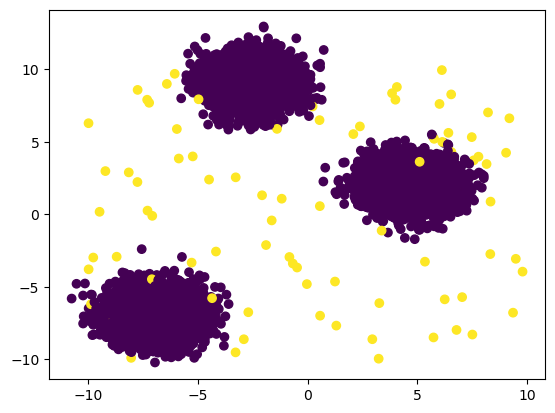

In [1]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from capymoa.stream import NumpyStream

# generate normal data points
n_samples = 10000
n_features = 2
n_clusters = 3
X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_clusters, random_state=42)

# generate anomalous data points
n_anomalies = 100 # the anomaly rate is 1%
anomalies = np.random.uniform(low=-10, high=10, size=(n_anomalies, n_features))

# combine the normal data points with anomalies
X = np.vstack([X, anomalies])
y = np.hstack([y, [1]*n_anomalies])  # Label anomalies with 1
y[:n_samples] = 0  # Label normal points with 0

# shuffle the data
idx = np.random.permutation(n_samples + n_anomalies)
X = X[idx]
y = y[idx]

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.show()

# create a NumpyStream from the combined dataset
feature_names = [f"feature_{i}" for i in range(n_features)]
target_name = "class"

## 2. Unsupervised Anomaly Detection for data streams

* Recent research has been focused on unsupervised anomaly detection for data streams, as it is often difficult to obtain labeled data for training.
* Instead of using evaluation functions, we first use a basic **test-then-train loop** from scratch to evaluate the model's performance.
* Please notice that lower scores indicate higher anomaly likelihood.

In [2]:
from capymoa.anomaly import HalfSpaceTrees
from capymoa.evaluation import AnomalyDetectionEvaluator

stream_ad = NumpyStream(X, y, dataset_name="AnomalyDetectionDataset", feature_names=feature_names, target_name=target_name, target_type='categorical')
learner = HalfSpaceTrees(stream_ad.get_schema())
evaluator = AnomalyDetectionEvaluator(stream_ad.get_schema())
while stream_ad.has_more_instances():
    instance = stream_ad.next_instance()
    score = learner.score_instance(instance)
    evaluator.update(instance.y_index, score)
    learner.train(instance)
    
auc = evaluator.auc()
print(f"AUC: {auc:.2f}")

AUC: 0.94


## 3. High-level evaluation functions

* CapyMOA provides `prequential_evaluation_anomaly` as a high level function to assess Anomaly Detectors


### 3.1 ```prequential_evaluation_anomaly```
In this example, we use the ```prequential_evaluation_anomaly``` function with ```plot_windowed_results``` to plot AUC for HalfSpaceTrees on the synthetic data stream

AUC: 0.9353805


,instances,auc,s_auc,Accuracy,Kappa,Periodical holdout AUC,Pos/Neg ratio,G-Mean,Recall,KappaM
0,1000.0,0.956841,0.217535,0.059,0.000773,0.000000,0.007049,0.228837,1.0,-133.428571
1,2000.0,0.942269,0.199682,0.004,0.000000,0.956841,0.004016,0.000000,1.0,-180.090909
2,3000.0,0.918285,0.185046,0.014,0.000000,0.942269,0.014199,0.000000,1.0,-117.320000
3,4000.0,0.907253,0.176183,0.011,0.000000,0.918285,0.011122,0.000000,1.0,-108.888889
4,5000.0,0.962103,0.215296,0.009,0.000000,0.907253,0.009082,0.000000,1.0,-109.111111
5,6000.0,0.926633,0.199979,0.020,0.000000,0.962103,0.020408,0.000000,1.0,-89.461538
6,7000.0,0.972522,0.208208,0.007,0.000000,0.926633,0.007049,0.000000,1.0,-95.541667
7,8000.0,0.915341,0.184214,0.011,0.000000,0.972522,0.011122,0.000000,1.0,-94.325301
8,9000.0,0.956985,0.213749,0.007,0.000000,0.915341,0.007049,0.000000,1.0,-98.300000
9,10000.0,0.947304,0.195486,0.009,0.000000,0.956985,0.009082,0.000000,1.0,-99.101010


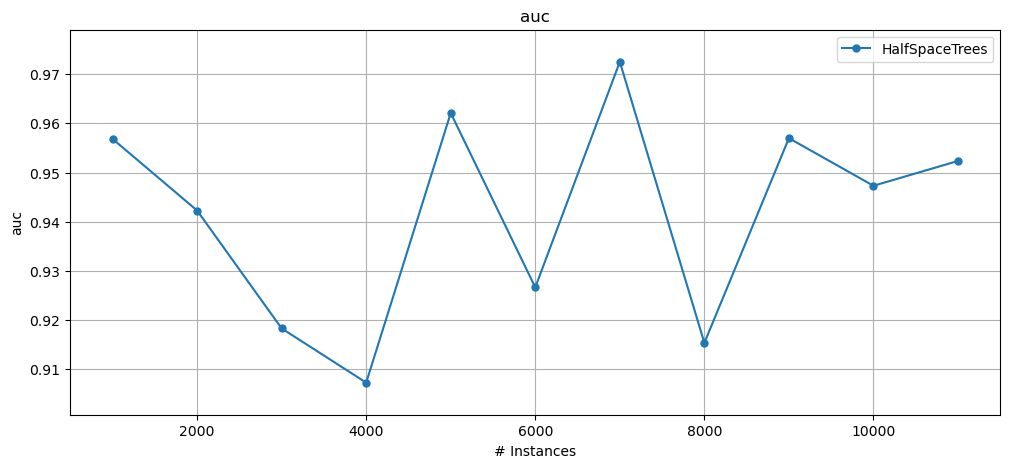

In [3]:
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.anomaly import HalfSpaceTrees
from capymoa.evaluation import prequential_evaluation_anomaly

stream_ad = NumpyStream(X, y, dataset_name="AnomalyDetectionDataset", feature_names=feature_names, target_name=target_name, target_type='categorical')
hst = HalfSpaceTrees(schema=stream_ad.get_schema())

results_hst = prequential_evaluation_anomaly(stream=stream_ad, learner=hst, window_size=1000)

print(f"AUC: {results_hst.auc()}")
display(results_hst.windowed.metrics_per_window())
plot_windowed_results(results_hst, metric="auc", save_only=False)

## 3.2 Autoencoder

AUC: 0.4883915


,instances,auc,s_auc,Accuracy,Kappa,Periodical holdout AUC,Pos/Neg ratio,G-Mean,Recall,KappaM
0,1000.0,0.563013,-0.208862,0.008,0.000014,0.000000,0.007049,0.031734,1.00,-140.714286
1,2000.0,0.476782,-0.135474,0.004,0.000000,0.563013,0.004016,0.000000,1.00,-180.090909
2,3000.0,0.553463,-0.160212,0.015,0.000028,0.476782,0.014199,0.031846,1.00,-117.200000
3,4000.0,0.563655,-0.185599,0.011,0.000000,0.553463,0.011122,0.000000,1.00,-108.888889
4,5000.0,0.552416,-0.155626,0.010,0.000018,0.563655,0.009082,0.031766,1.00,-109.000000
5,6000.0,0.463878,-0.144336,0.020,-0.001963,0.552416,0.020408,0.031135,0.95,-89.461538
6,7000.0,0.424471,-0.120205,0.007,0.000000,0.463878,0.007049,0.000000,1.00,-95.541667
7,8000.0,0.335049,-0.045124,0.012,0.000022,0.424471,0.011122,0.031798,1.00,-94.228916
8,9000.0,0.272910,-0.038636,0.007,0.000000,0.335049,0.007049,0.000000,1.00,-98.300000
9,10000.0,0.645420,-0.213498,0.009,0.000000,0.272910,0.009082,0.000000,1.00,-99.101010


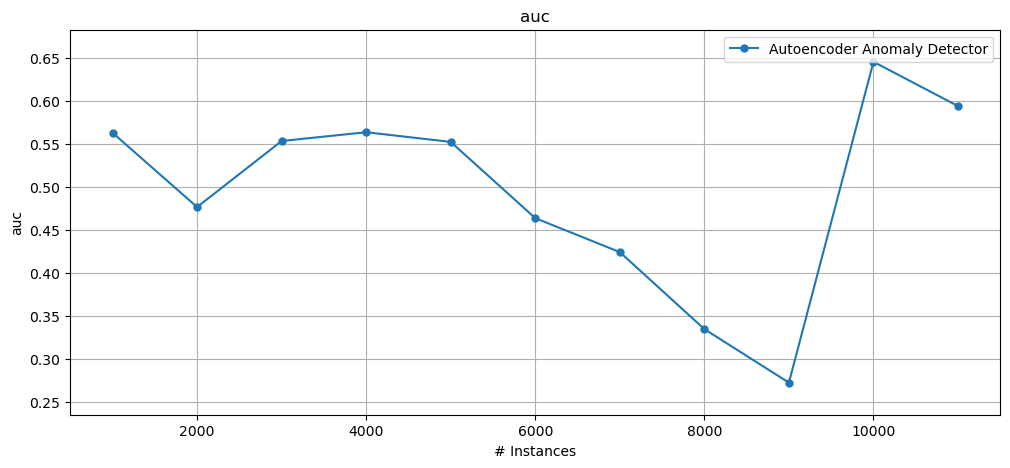

In [4]:
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.anomaly import Autoencoder
from capymoa.evaluation import prequential_evaluation_anomaly

stream_ad = NumpyStream(X, y, dataset_name="AnomalyDetectionDataset", feature_names=feature_names, target_name=target_name, target_type='categorical')
ae = Autoencoder(schema=stream_ad.get_schema(), hidden_layer=1)

results_ae = prequential_evaluation_anomaly(stream=stream_ad, learner=ae, window_size=1000)

print(f"AUC: {results_ae.auc()}")
display(results_ae.windowed.metrics_per_window())
plot_windowed_results(results_ae, metric="auc", save_only=False)

## 3.3 Online Isolation Forest

AUC: 0.2808045


,instances,auc,s_auc,Accuracy,Kappa,Periodical holdout AUC,Pos/Neg ratio,G-Mean,Recall,KappaM
0,1000.0,0.365991,0.047699,0.040,0.000481,0.000000,0.007049,0.182298,1.000000,-136.142857
1,2000.0,0.194277,0.001615,0.003,-0.002002,0.365991,0.004016,0.000000,0.750000,-180.272727
2,3000.0,0.150536,0.000231,0.013,-0.002002,0.194277,0.014199,0.000000,0.928571,-117.440000
3,4000.0,0.286653,-0.001175,0.013,-0.001941,0.150536,0.011122,0.052513,0.909091,-108.666667
4,5000.0,0.388553,-0.000007,0.012,-0.003936,0.286653,0.009082,0.062643,0.777778,-108.777778
5,6000.0,0.290893,-0.001192,0.020,-0.003934,0.388553,0.020408,0.042857,0.900000,-89.461538
6,7000.0,0.128039,0.000174,0.004,-0.006018,0.290893,0.007049,0.000000,0.571429,-95.833333
7,8000.0,0.171109,0.000686,0.012,-0.001961,0.128039,0.011122,0.042877,0.909091,-94.228916
8,9000.0,0.348871,0.000688,0.009,-0.003967,0.171109,0.007049,0.053640,0.714286,-98.100000
9,10000.0,0.315955,-0.000560,0.008,-0.003994,0.348871,0.009082,0.028015,0.777778,-99.202020


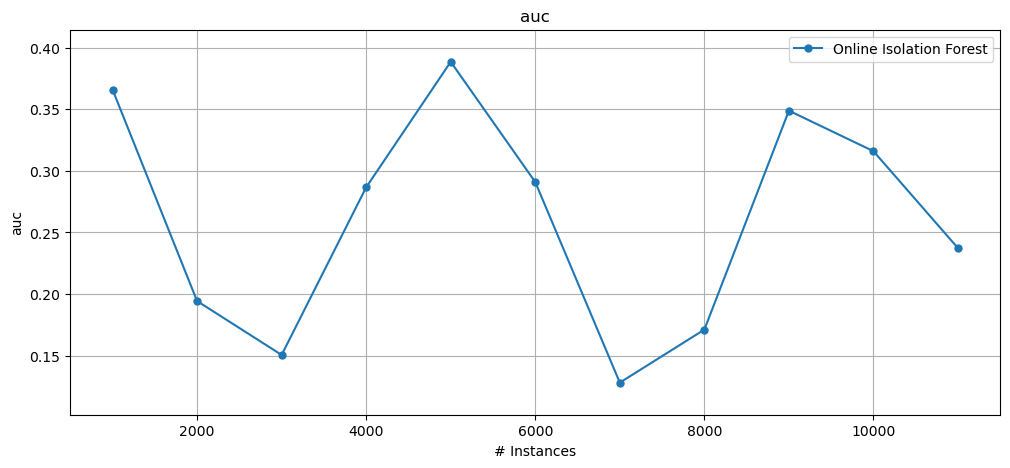

In [5]:
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.anomaly import OnlineIsolationForest
from capymoa.evaluation import prequential_evaluation_anomaly

stream_ad = NumpyStream(X, y, dataset_name="AnomalyDetectionDataset", feature_names=feature_names, target_name=target_name, target_type='categorical')
oif = OnlineIsolationForest(schema=stream_ad.get_schema(), num_trees=10)

results_oif = prequential_evaluation_anomaly(stream=stream_ad, learner=oif, window_size=1000)

print(f"AUC: {results_oif.auc()}")
display(results_oif.windowed.metrics_per_window())
plot_windowed_results(results_oif, metric="auc", save_only=False)

## 4 Comparing algorithms

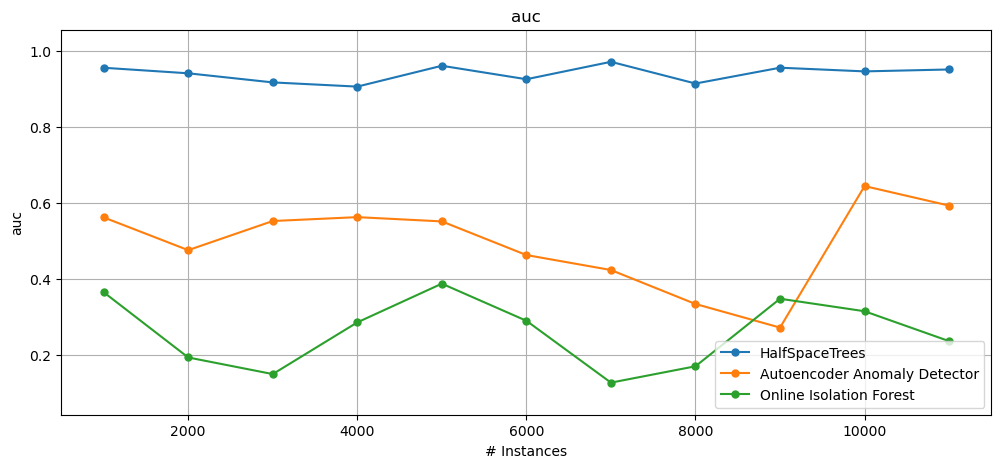

In [6]:
plot_windowed_results(results_hst, results_ae, results_oif, metric="auc", save_only=False)